In [1]:
# Copyright(c) 2019-2020 Intel Corporation All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#   * Redistributions of source code must retain the above copyright
#     notice, this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer in
#     the documentation and/or other materials provided with the
#     distribution.
#   * Neither the name of Intel Corporation nor the names of its
#     contributors may be used to endorse or promote products derived
#     from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## 1. One-shot learning using External Plexiform Layer (EPL) network ##

In this tutorial, we show how to setup, train and test a neuromorphic algorithm for one-shot pattern learning inspired by the External Plexiform Layer (EPL) network of the mammalian olfactory bulb. While the algorithm implemented by the network learns to recognize "odors" (more precisely, using odor chemosensor array data), it can be used to learn any other patterns as the EPL network basically implements a spatio-temporal attractor (STA) network. After the EPL/STA network "learns" an odor/pattern, even if a noise corrupted version of the learned pattern (test sample) is presented, the network activity settles down into the attractor state of the learned pattern. This gives the ability for the network to learn (more precisely, recall) from a single exposure to a pattern (i.e. one-shot learning). However, if the noise in the test sample is very high, then the network may not be able to recall the pattern as it may not settle down in the attractor state of the learned pattern. However, in practice, we notice that the EPL network is robust to high levels of noise.

## 2. EPL network setup ##

#### EPL network structure ####
The biologically inspired version of the EPL network is a collection of "columns", where each column is composed of few mitral cells (MCs) and many granule cells (GCs) which act as interneurons. The MCs in a column have sparse, random and excitatory connections to all GCs, including those in other columns. The MC->GC weights are plastic (E-STDP learning). The GCs in a column only have inhibitory connections with MCs in the same column. The GC->MC delays are plastic (I-STDP learning). 

The inputs to the network are presented to the MCs as bias currents which causes the MCs to spike. Each MC is fed a bias current from one receptor neuron (in biology) and from one sensor of a chemosensor array in the case of an "artificial nose" implementation. Therefore, the timing of the MC output spike depends on the strength of the MC input bias current.

Usually, a group of GCs (say five) in each column are allocated to learn one pattern. The E-STDP learning rule for the MC->GC connections helps to strengthen the weights which causally excite the GCs and prune those weights which don't excite the GCs. Meanwhile, as the excited GCs spike, the inhibitory delay of the GC->MC box synapses increases until the various MCs responsible for exciting a particular GC no longer send any pre-synaptic spikes. Thus, the E-STDP learning rule for the sparse MC->GC connections helps the GC neurons to develop a receptive field which is sensitive to higher order features of the MC input patterns.

The EPL network is tightly synchronized by oscillatory circuits. There are two oscillatory cycles (theta and gamma) which precisely control the operation of the network. The gamma oscialltions are fine grained (say, 1 gamma cycle = 40 timesteps), whereas the thetha oscillations are coase grained and composed of many gamma cycles (say, 1 thetha cycle = 50 gamma cycles during training/ 5 gamma cycles during testing). In each gamma cycle, the MC neurons are on for half of the gamma cycle and off for the other half. In the positive theta cycle, the network is consistently exposed to a pattern (i.e. "sniffs" the input), learns and settles into a spatio-temporal attractor state (STSA) for that pattern. Next, during the negative theta cycle (also referred to as idle thetha cycle), the network is not presented any inputs. This helps the network to get rid of any transient neuronal activity.
The output of the network, is the spiking pattern of the various MCs in all the columns. Thus the MC layer serves as both the input and output layer for the network where the GCs act as the inhibitory interneurons.

In [2]:
# import the required modules
from nxsdk_modules_ncl.epl.src.multi_pattern_learning.epl_multi_pattern_learning import EPLMultiPatternLearning
from nxsdk_modules_ncl.epl.src.multi_pattern_learning.epl_parameters import ParamemtersForEPL


## 3. One-shot learning of a single odor pattern ##

We now show how to setup an EPL network to learn a single odor pattern. The odor we want to learn is exposed to a chemo-sensor array of say N sensors. Each sensor binds to a particular part of the odor molecule and emits a reading. Thus the input to the MC neurons is the values of those sensor reading. 

In [3]:
# Define the parameters using a utility class that sets up the various default parameters
eplParams = ParamemtersForEPL()
# list the various parameters
eplParams.showDefaults()

numPatterns=1
numColumns=72
numMCsPerColumn=1
numGCsPerPatternPerColumn=5
numDelaysMCToGC=1
minDelaysMCToGC=16
gammaCycleDuration=40
connProbMCToGC=0.2
useRandomSeed=False
randomGenSeed=0
numGammaCyclesTrain=45
numGammaCyclesTest=5
numGammaCyclesIdle=5
useLMTSpikeCounters=False
logSNIPs=False
executionTimeProbe=False


From the above cell, we notice that we are setting up a network to learn 1 pattern (odor). The network has 72 columns with 1 MC per each column and 5 GCs per column for each pattern. 

In [4]:
#modify only the ones we need. Here we set the seed for the random number generator to 100 so that the results are repeatble.
eplParams.useRandomSeed=True
eplParams.randomGenSeed=100

In [5]:
# We now setup an EPL network to learn and recall patterns based on the parameters we set
epl = EPLMultiPatternLearning(eplParams=eplParams)

createMCAndSTONetwork took 0.06940 secs
createMCToGCNetwork took 0.63326 secs
compileAndGetBoard took 1.25281 secs


### 3a. Create synthetic training and testing datasets ###

we now generate "synthetic data" for an odor/pattern by creating synthetic odor chemosensor array data (for an odor/pattern) and also generate noise corrupted test samples for that pattern. In general we can feed any arbitraty patterns we want to learn

In [6]:
#generate synthetic training data for 1 pattern
x = epl.genTrainingData(numPatterns=1)
#generate synthetic testing data using the pattern to be learned. We take the training pattern, and randomly corrupt a fraction
#of the sensor readings (occlusion factor) with impulse noise
numTestSamples=100
# occlusionFactor=0.6 i.e. 60% of the sensor values are randomly corrupted with noise
y = epl.genTestingData(trainingData=x, numTestSamples=numTestSamples, occlusionFactor=0.6)


In [7]:
#Display the train and test samples
for pattern in x:
    print("Training data (single pattern) = {} \n".format(pattern))
for i, testPattern in enumerate(y[:5]):
    print("Test pattern #{} = {} \n".format(i+1, testPattern))

Training data (single pattern) = [0, 0, 16, 16, 4, 4, 12, 0, 8, 0, 0, 8, 8, 0, 0, 8, 0, 0, 0, 16, 0, 4, 0, 8, 8, 0, 8, 16, 0, 4, 12, 12, 12, 12, 16, 4, 16, 0, 16, 16, 12, 0, 12, 0, 4, 8, 8, 12, 0, 0, 0, 0, 8, 0, 4, 0, 16, 4, 8, 0, 0, 8, 8, 0, 0, 4, 0, 16, 0, 0, 0, 8] 

Test pattern #1 = [11, 4, 5, 0, 4, 0, 10, 0, 8, 16, 0, 12, 5, 0, 12, 8, 0, 12, 14, 6, 6, 4, 5, 8, 8, 2, 14, 16, 4, 4, 12, 12, 13, 16, 3, 9, 4, 3, 7, 16, 12, 1, 12, 0, 14, 13, 11, 12, 0, 2, 2, 1, 14, 13, 0, 4, 16, 4, 15, 0, 0, 8, 8, 0, 3, 4, 0, 2, 0, 9, 3, 8] 

Test pattern #2 = [16, 8, 0, 16, 4, 16, 12, 3, 5, 0, 0, 8, 8, 1, 7, 8, 0, 14, 0, 16, 3, 7, 11, 8, 8, 0, 8, 16, 10, 4, 3, 9, 3, 12, 16, 9, 9, 0, 14, 16, 12, 0, 12, 6, 4, 10, 8, 2, 5, 10, 4, 6, 13, 2, 4, 2, 10, 6, 10, 8, 4, 8, 3, 14, 0, 6, 0, 16, 16, 0, 5, 15] 

Test pattern #3 = [14, 10, 16, 1, 4, 8, 12, 15, 8, 1, 2, 11, 1, 8, 0, 14, 9, 12, 11, 16, 0, 10, 5, 4, 5, 10, 15, 12, 0, 4, 13, 12, 12, 7, 16, 4, 15, 0, 16, 16, 12, 0, 12, 0, 3, 16, 6, 12, 0, 0, 0, 5, 2, 0, 7,

### 3b. Training, testing and evaluation of performance ###

In [8]:
# We now train the network by presenting one pattern for 45 gamma cycles(numGammaCyclesTrain=45),
# where each gamma cycle is 40 timesteps (gammaCycleDuration=40)
# After presenting the training pattern, the network is not fed any inputs for 5 gamma cycles (numGammaCyclesIdle=5)
epl.fit(trainingSet=x, testingSet=y);

_genCodeForConstants took 0.03259 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:45739
INFO:DRV:      Host server up..............Done 0.20s
Compiling in directory : /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699922.4587395
Include dir is : /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk_modules/epl/src/multi_pattern_learning/snips
Compiling -c /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699922.4587395/initnetwork_0_0.c
gcc -Wall -I/home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk_modules/epl/src/multi_pattern_learning/snips -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -o /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699922.4587395/initnetwork_0_0.c.o -c /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/

INFO:DRV:      Compiling Embedded snips....Done 0.48s
INFO:DRV:      Encoding axons/synapses.....Done 0.05s
INFO:DRV:      Encoding probes.............Done 0.46ms
INFO:DRV:      Booting up..................Done 2.60s
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring probes.........Done 3.60ms
INFO:DRV:      Transferring spikes.........Done 0.05ms


In [9]:
# We now test the ability of the network to recall 100 noise corrputed samples of the trained pattern
# During testing, each pattern is presented to the network for 5 gamma cycles(numGammaCyclesTest=5)
# In between the presentation of two test samples, the network is not fed any 
#inputs for 5 gamma cycles (numGammaCyclesIdle=5)
epl.predict();

INFO:DRV:      Configuring registers.......Done 2.46ms
INFO:DRV:      Transferring probes.........Done 0.19ms
INFO:DRV:      Transferring spikes.........Done 0.05ms
INFO:DRV:      Executing...................Done 8.55s
INFO:DRV:      Processing timeseries.......Done 0.53s


In [10]:
# we now evaluate the performance of the network and see how many test samples (i.e. noise corrupted
# versions of the trained pattern) can be recalled with more than 80% "similarity". 
#We can use various similarity metrics. In this case, we use Jaccard Similarity.
#The chosen similarity metric allows us to compute how close the spatio-temporal spiking activity 
#of the test sample is to that of the trained sample.

#plot the spatio-temporal spiking activity of the last (100th) test sample
epl.evaluate(similarityThreshold=0.8)

*****Execution Report*****
1 patterns presented. 100 test samples for each pattern
Classification performance = 100.0%; for similarity threshold = 0.8 
            


In [11]:
# next we evaluate the performance for more stringent requirements in the similarity of
# the spatio-temporal spiking activity of the network 
epl.evaluate(similarityThreshold=0.99)

*****Execution Report*****
1 patterns presented. 100 test samples for each pattern
Classification performance = 97.0%; for similarity threshold = 0.99 
            


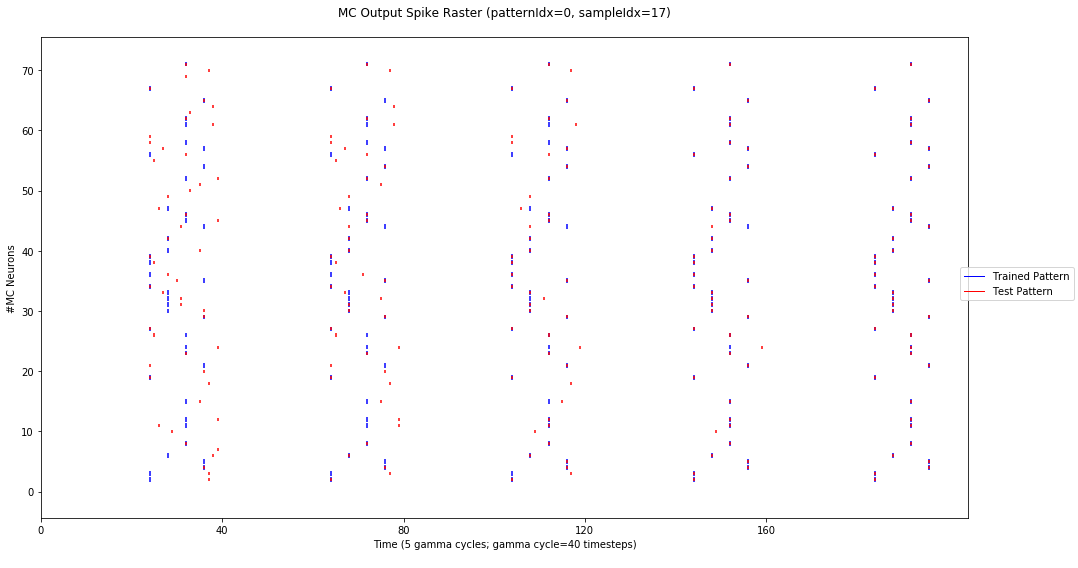

In [12]:
# let us visualize the spatio-temporal spiking activity of the network. 
#Let us see the spike raster for the 18th testSample (i.e sampleIdx=17)
"""%matplotlib notebook"""
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
epl.showRasterPlot(patternIdx=0, sampleIdx=17)

### 3c. Discussion ###
In the above spike raster plot, we look at the spatio-temporal spiking activity (STSA) of the various MC neurons for each of the 5 gamma cycles for which the network was presented a test input. In particular, the above plot is for the 18th test sample.
In first gamma cycle (left most part of the spike raster plot), the STSA of the network for the training pattern is shown in blue. Whereas, the STSA of the network for the test sample (which is a noise corrupted version of the trained pattern) is shown in red. In the first gamma cycle(first 40 timesteps), we notice that there is significant difference between the STSAs of the learned and test patterns. But, by the fifth gamma cycle, we notice that the STSA of the test sample "settles down" to that of the STSA of the trained pattern, thereby enabling the network to recall the pattern it learned using one-shot learning. 

## 4. One-shot learning of multiple patterns ##

### 4a. Learning images of digits ###
In this section, we will look at how we can learn patterns which are different from odors. We will see how the EPL network can learn images of 6 different digits and recall the learned digit even when noise corrupted versions of the learned image of the digit are presented.

In [13]:
from sklearn import datasets
import numpy as np

In [14]:
# load the digits dataset which consists of 8X8 images of digits
digits = datasets.load_digits()
images = digits.images
targets = digits.target
# create a map of {digt->list of images of the digits}
image_dict = {n : [] for n in range(10)}
for t, img in zip(targets, images):
    image_dict[t].append(img)

### 4b. generate and visualize training images/patterns ###

In [15]:
numPatterns = 6
#randomly choose 6 digits
digits = [0, 2, 4, 5, 7, 9]

In [16]:
#define utility functions
#create the training dataset by choosing the appropriate images of the digts to be learned
def get_training_data(digits, fourX=True, idx=0):
    train_data = []
    for digit in digits:
        training_image = image_dict[digit][idx]
        # print(training_image)
        training_image = np.ndarray.astype(training_image, int)
        if fourX: training_image = (training_image//4)*4
        training_image = np.ndarray.flatten(training_image).tolist()
        # print(training_image)
        train_data.append(training_image)
    return train_data



In [17]:
# generate the training data
train_data = get_training_data(digits=digits)

In [18]:
# display the images of the patterns (digits) to be learned
def plot_images(digits, data, title):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axs.flat):
        img = data[i]
        img = np.reshape(img, (8,8))
        ax.imshow(img, interpolation=None, cmap='viridis')
        ax.set_title(str(digits[i]))
    plt.tight_layout()
    fig.suptitle(title, fontsize=16)
    plt.show()


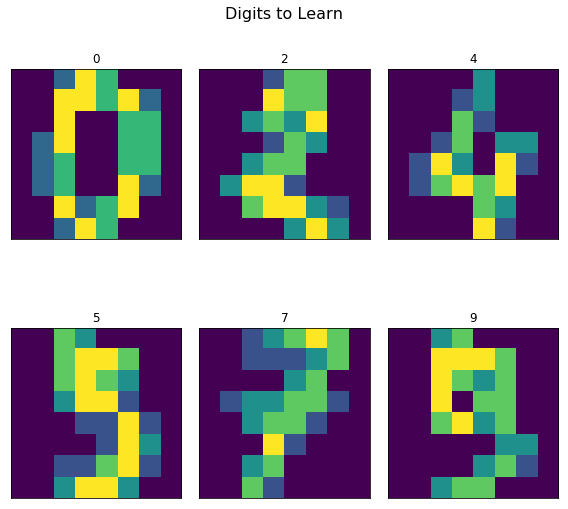

In [19]:
    
# visulize the training data    
plot_images(digits, train_data, title="Digits to Learn")

### 4c. Set up the EPL network to learn and recall images of digits ###

In [20]:
# define the parameters
plParams = ParamemtersForEPL()
eplParams.numPatterns = numPatterns
# Image size is 8X8 and we are using only 1MC per column
eplParams.numColumns = 64 
eplParams.numMCsPerColumn = 1
# Use 5 GCs per column per pattern
eplParams.numGCsPerPatternPerColumn = 5
eplParams.connProbMCToGC = 0.2
eplParams.numDelaysMCToGC = 2
eplParams.useRandomSeed = True
eplParams.randomGenSeed = 100
eplParams.numGammaCyclesTrain = 45
# create the network
epl = EPLMultiPatternLearning(eplParams=eplParams)

createMCAndSTONetwork took 0.06080 secs
createMCToGCNetwork took 5.37041 secs
compileAndGetBoard took 8.11965 secs


### 4d. Generate noisy test samples of the trained patterns (digits) ###

In [21]:
# generate 5 noisy test samples for each pattern
numTestSamples = 5
occlusionPercent = 0.2 # randomly perturb only 20% of the image pixels
test_data = epl.generateTestingData(trainingData=train_data,
                                occlusionPercent=occlusionPercent,
                                numTestSamples=numTestSamples)

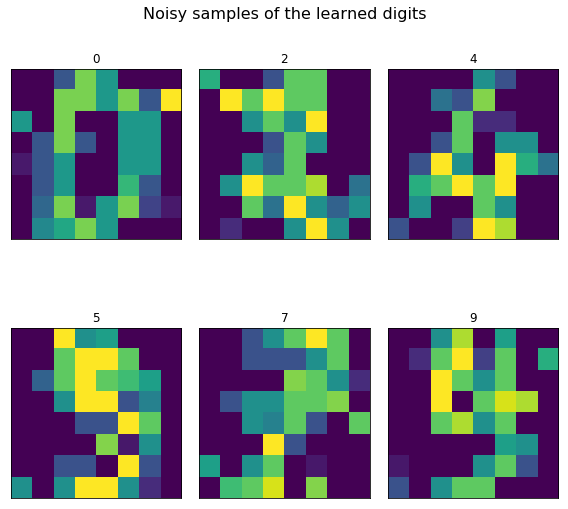

In [22]:
#visualize the test data by displaying the 3rd test sample for each pattern
test_data_subset = []
sampleIdx=3
for patternIdx in range(numPatterns):
    idx = patternIdx * numTestSamples + sampleIdx
    test_data_subset.append(test_data[idx])

#plot the 3rd test sample for each pattern
plot_images(digits, test_data_subset, title="Noisy samples of the learned digits")



### 4e. Train, Test and Evaluate performance ###

In [23]:
epl.fit(trainingSet=train_data, testingSet=test_data)


_genCodeForConstants took 0.00984 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:35239
INFO:DRV:      Host server up..............Done 0.18s
Compiling in directory : /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699952.0448399
Include dir is : /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk_modules/epl/src/multi_pattern_learning/snips
Compiling -c /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699952.0448399/initnetwork_0_0.c
gcc -Wall -I/home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk_modules/epl/src/multi_pattern_learning/snips -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -o /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699952.0448399/initnetwork_0_0.c.o -c /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/

INFO:DRV:      Compiling Embedded snips....Done 0.79s
INFO:DRV:      Encoding axons/synapses.....Done 0.27s
INFO:DRV:      Booting up..................Done 2.66s
INFO:DRV:      Encoding probes.............Done 0.21ms
INFO:DRV:      Transferring spikes.........Done 0.09ms
INFO:DRV:      Transferring probes.........Done 3.22ms
INFO:DRV:      Configuring registers.......Done 0.21s


In [24]:
epl.predict()


INFO:DRV:      Transferring spikes.........Done 0.07ms
INFO:DRV:      Transferring probes.........Done 0.08ms
INFO:DRV:      Configuring registers.......Done 3.39ms
INFO:DRV:      Executing...................Done 2.74s
INFO:DRV:      Processing timeseries.......Done 0.28s


In [25]:
epl.evaluate(similarityThreshold=0.85)


*****Execution Report*****
6 patterns presented. 5 test samples for each pattern
Classification performance = 83.0%; for similarity threshold = 0.85 
            


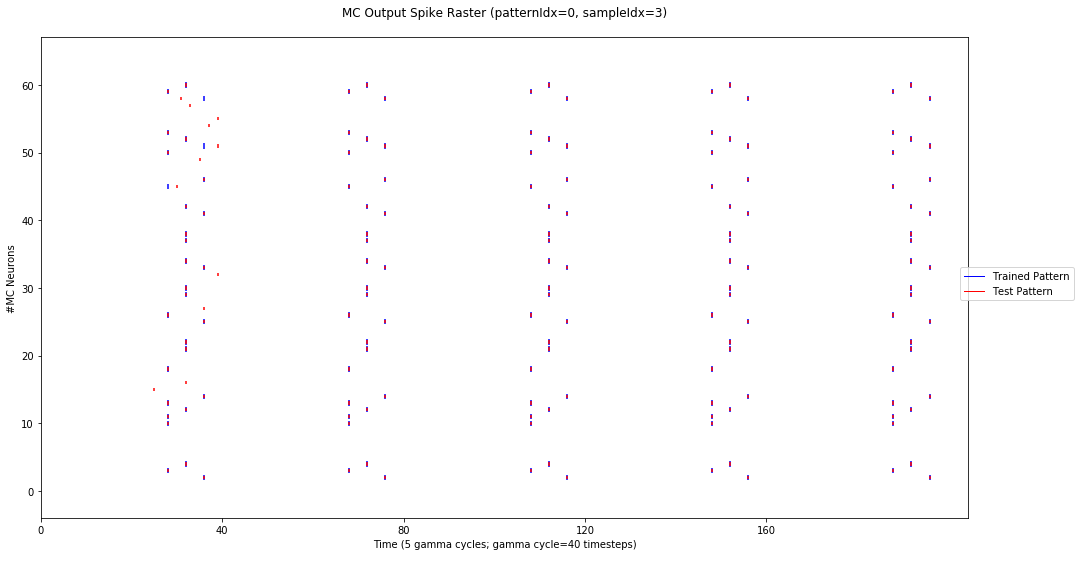

In [26]:
epl.showRasterPlot(patternIdx=0, sampleIdx=3)

### 4f. Improving the accuracy by tuning the hyper parameters ###
There are various hyper parameters in the network that can be tuned. With the network parameters we chose before, the accuracy obtained was 83%. Let us try to improve this accuracy by varying one of the hyperparameters and see what happens...

In [27]:
#Change the number of dendrites between MC->GC connections
eplParams.numDelaysMCToGC = 3 # was 2 before

#create a new network and redo the above process
epl = EPLMultiPatternLearning(eplParams=eplParams)

createMCAndSTONetwork took 0.07360 secs
createMCToGCNetwork took 7.93065 secs
compileAndGetBoard took 12.31260 secs


In [28]:
# This dumps a lot of output
epl.fit(trainingSet=train_data, testingSet=test_data)
epl.predict()


_genCodeForConstants took 0.09278 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:35663
INFO:DRV:      Host server up..............Done 0.36s
Compiling in directory : /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699985.457973
Include dir is : /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk_modules/epl/src/multi_pattern_learning/snips
Compiling -c /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699985.457973/initnetwork_0_0.c
gcc -Wall -I/home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk_modules/epl/src/multi_pattern_learning/snips -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -o /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1561699985.457973/initnetwork_0_0.c.o -c /home/sparasa/ncl/gold/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/156

INFO:DRV:      Compiling Embedded snips....Done 0.63s
INFO:DRV:      Encoding axons/synapses.....Done 0.31s
INFO:DRV:      Booting up..................Done 2.60s
INFO:DRV:      Encoding probes.............Done 0.20ms
INFO:DRV:      Transferring spikes.........Done 0.07ms
INFO:DRV:      Transferring probes.........Done 3.57ms
INFO:DRV:      Configuring registers.......Done 0.22s
INFO:DRV:      Transferring spikes.........Done 0.35ms
INFO:DRV:      Transferring probes.........Done 0.11ms
INFO:DRV:      Configuring registers.......Done 3.41ms
INFO:DRV:      Executing...................Done 2.74s
INFO:DRV:      Processing timeseries.......Done 0.28s


In [29]:
# Accuracy improves to 97% instead of 83% from before
epl.evaluate(similarityThreshold=0.85)

*****Execution Report*****
6 patterns presented. 5 test samples for each pattern
Classification performance = 97.0%; for similarity threshold = 0.85 
            


## Conclusion ##

In this tutorial, we have shown very briefly about how to use the EPL network to impletement one-shot learning of multiple patterns and perform a recall/classification from noisy version of the learned patterns. We have used how the EPL network which was originally developed to learn odors can be repurposed to learned other kinds of arbitraty patterns like images. 